In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import random
from tqdm import tqdm

# Chargement des fichiers
path = r'D:/mes_travails/powerBI/data'

ratings = pd.read_csv(f'{path}/ratings.dat', sep='::', engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_csv(f'{path}/movies.dat', sep='::', engine='python',
                     names=['MovieID', 'Title', 'Genres'], encoding='latin1')
users = pd.read_csv(f'{path}/users.dat', sep='::', engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin1')

# Nettoyage et harmonisation des titres
movies['Title'] = (movies['Title']
                   .str.lower()
                   .str.replace(r'\(\d{4}\)', '', regex=True)
                   .str.replace(r'[^\w\s]', '', regex=True)
                   .str.strip())

# Fusion et nettoyage
data = pd.merge(pd.merge(ratings, users), movies)
data = data.drop_duplicates()
data.reset_index(drop=True, inplace=True)

# Transformation des genres en colonnes
genres_dummies = data['Genres'].str.get_dummies(sep='|')
data = pd.concat([data, genres_dummies], axis=1)

print(" Données préparées :", data.shape)


 Données préparées : (1000209, 28)


In [2]:
user_movie_matrix = data.pivot_table(index='UserID', columns='Title', values='Rating', fill_value=0)
print(" Matrice utilisateur x film :", user_movie_matrix.shape)


 Matrice utilisateur x film : (6040, 3664)


In [3]:
# Normalisation des notes (centrage par utilisateur)
user_mean = user_movie_matrix.replace(0, np.nan).mean(axis=1)
user_matrix_centered = user_movie_matrix.sub(user_mean, axis=0).fillna(0)

user_similarity = cosine_similarity(user_matrix_centered)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)


In [4]:
movie_features = data[['Title'] + list(genres_dummies.columns)].drop_duplicates('Title').set_index('Title')
movie_similarity = cosine_similarity(movie_features.values)
movie_similarity_df = pd.DataFrame(movie_similarity, index=movie_features.index, columns=movie_features.index)
print(" Similarités film-film calculées :", movie_similarity_df.shape)


 Similarités film-film calculées : (3664, 3664)


In [5]:
def recommander_collaboratif(user_id, n_similaires=5, n_recommandations=10):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:n_similaires+1]
    candidate_movies = user_movie_matrix.loc[similar_users.index]
    
    weighted_ratings = candidate_movies.T.dot(similar_users) / similar_users.sum()
    rated_movies = user_movie_matrix.loc[user_id]
    weighted_ratings = weighted_ratings[rated_movies == 0]
    
    return list(weighted_ratings.sort_values(ascending=False).head(n_recommandations).index)


In [6]:
def recommander_contenu(user_id, n_recommandations=10):
    user_rated = user_movie_matrix.loc[user_id]
    liked_movies = user_rated[user_rated >= 4].index
    if len(liked_movies) == 0:
        return []
    
    scores = movie_similarity_df[liked_movies].sum(axis=1)
    scores = scores[user_rated == 0]
    
    return list(scores.sort_values(ascending=False).head(n_recommandations).index)


In [7]:
def recommander_films_hybride(user_id, alpha=0.6, n_recommandations=10):
    collab = recommander_collaboratif(user_id, n_similaires=5, n_recommandations=n_recommandations)
    contenu = recommander_contenu(user_id, n_recommandations=n_recommandations)
    
    combined = {}
    
    # Normalisation des scores : 1 pour le plus haut, décroissant pour les suivants
    for i, movie in enumerate(collab):
        combined[movie] = combined.get(movie, 0) + alpha * (n_recommandations - i)/n_recommandations
    for i, movie in enumerate(contenu):
        combined[movie] = combined.get(movie, 0) + (1-alpha) * (n_recommandations - i)/n_recommandations
    
    top_movies = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:n_recommandations]
    return [movie for movie, score in top_movies]


In [8]:
def evaluer_top_n(user_movie_matrix, recommander_films_hybride, n_recommandations=10, sample_size=100, alpha=0.6, n_test_movies=3):
    users = random.sample(list(user_movie_matrix.index), min(sample_size, len(user_movie_matrix)))
    precisions, recalls, hit_rates = [], [], []

    for user_id in tqdm(users, desc="Évaluation Top-N"):
        user_ratings = user_movie_matrix.loc[user_id]
        liked_movies = list(user_ratings[user_ratings >= 4].index)
        if len(liked_movies) < n_test_movies:
            continue

        # Sélection aléatoire de quelques films aimés à cacher
        test_movies = random.sample(liked_movies, n_test_movies)
        original_ratings = user_ratings[test_movies].copy()
        user_movie_matrix.loc[user_id, test_movies] = 0  # masquer

        #  correction ici : utilisation du bon paramètre
        recommandations = recommander_films_hybride(user_id, alpha=alpha, n_recommandations=n_recommandations)

        if recommandations is None or len(recommandations) == 0:
            user_movie_matrix.loc[user_id, test_movies] = original_ratings
            continue

        recommended_movies = set(recommandations)
        true_positives = len(set(test_movies) & recommended_movies)

        precisions.append(true_positives / n_recommandations)
        recalls.append(true_positives / n_test_movies)
        hit_rates.append(1 if true_positives > 0 else 0)

        # restaurer les notes
        user_movie_matrix.loc[user_id, test_movies] = original_ratings

    precision_moy = np.mean(precisions) if precisions else 0
    recall_moy = np.mean(recalls) if recalls else 0
    hit_rate_moy = np.mean(hit_rates) if hit_rates else 0

    print(f"\n Évaluation Top-{n_recommandations} :")
    print(f" Précision moyenne : {precision_moy:.4f}")
    print(f" Rappel moyen     : {recall_moy:.4f}")
    print(f" Hit rate moyen   : {hit_rate_moy:.4f}")

    return precision_moy, recall_moy, hit_rate_moy


In [9]:
precision, recall, hit_rate = evaluer_top_n(user_movie_matrix, recommander_films_hybride,
                                            n_recommandations=10, sample_size=100, alpha=0.6, n_test_movies=3)


Évaluation Top-N: 100%|██████████| 100/100 [00:04<00:00, 21.43it/s]


 Évaluation Top-10 :
 Précision moyenne : 0.0830
 Rappel moyen     : 0.2767
 Hit rate moyen   : 0.6500



 Évaluation pour alpha = 0.0


Évaluation Top-N: 100%|██████████| 80/80 [00:04<00:00, 16.50it/s]



 Évaluation Top-10 :
 Précision moyenne : 0.0075
 Rappel moyen     : 0.0250
 Hit rate moyen   : 0.0625

 Évaluation pour alpha = 0.2


Évaluation Top-N: 100%|██████████| 80/80 [00:03<00:00, 20.60it/s]



 Évaluation Top-10 :
 Précision moyenne : 0.0400
 Rappel moyen     : 0.1333
 Hit rate moyen   : 0.3500

 Évaluation pour alpha = 0.4


Évaluation Top-N: 100%|██████████| 80/80 [00:03<00:00, 23.73it/s]



 Évaluation Top-10 :
 Précision moyenne : 0.0525
 Rappel moyen     : 0.1750
 Hit rate moyen   : 0.4375

 Évaluation pour alpha = 0.6


Évaluation Top-N: 100%|██████████| 80/80 [00:03<00:00, 21.44it/s]



 Évaluation Top-10 :
 Précision moyenne : 0.0838
 Rappel moyen     : 0.2792
 Hit rate moyen   : 0.5750

 Évaluation pour alpha = 0.8


Évaluation Top-N: 100%|██████████| 80/80 [00:03<00:00, 23.71it/s]



 Évaluation Top-10 :
 Précision moyenne : 0.0938
 Rappel moyen     : 0.3125
 Hit rate moyen   : 0.7125

 Évaluation pour alpha = 1.0


Évaluation Top-N: 100%|██████████| 80/80 [00:03<00:00, 22.16it/s]



 Évaluation Top-10 :
 Précision moyenne : 0.0875
 Rappel moyen     : 0.2917
 Hit rate moyen   : 0.6625


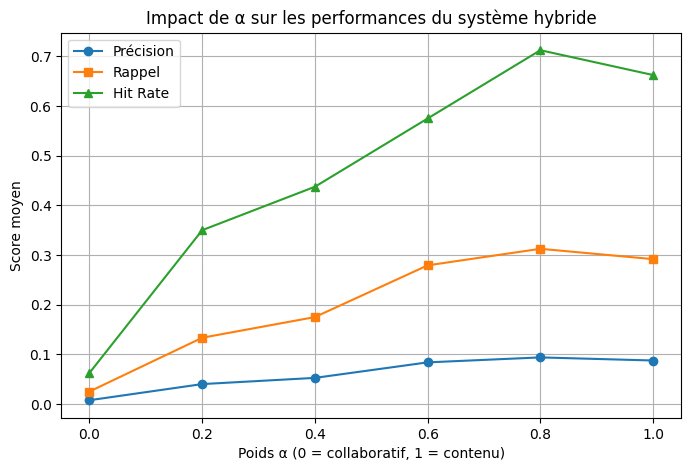

In [10]:
import matplotlib.pyplot as plt

alphas = np.linspace(0, 1, 6)  # 0.0, 0.2, 0.4, ..., 1.0
precisions, recalls, hits = [], [], []

for a in alphas:
    print(f"\n Évaluation pour alpha = {a:.1f}")
    p, r, h = evaluer_top_n(user_movie_matrix, recommander_films_hybride,
                            n_recommandations=10, sample_size=80, alpha=a, n_test_movies=3)
    precisions.append(p)
    recalls.append(r)
    hits.append(h)

# ====== Visualisation ======
plt.figure(figsize=(8,5))
plt.plot(alphas, precisions, 'o-', label="Précision")
plt.plot(alphas, recalls, 's-', label="Rappel")
plt.plot(alphas, hits, '^-', label="Hit Rate")

plt.xlabel("Poids α (0 = collaboratif, 1 = contenu)")
plt.ylabel("Score moyen")
plt.title("Impact de α sur les performances du système hybride")
plt.legend()
plt.grid(True)
plt.show()
